In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


# FDTD Library is open source MEEP
# https://meep.readthedocs.io/en/latest/

import meep as mp
#from meep.materials import SiO2, Si

%matplotlib widget

### Simulation Settings

In [2]:

# To understand MEEP units see https://meep.readthedocs.io/en/latest/Introduction/#units-in-meep
wavelength = 1.55 # wavelength can have arbitrary length units (we choose um)
f = 1/wavelength # Frequency is defined in "natural units" as (1 um)/wavelength

l,w,z = [60,40,0] # length,width,height of the simulation region (um)
r = 30 # Star Coupler Radius (um)
h = 25 # Star Coupler Height (um) (this gives the flat top/bottom if desired)

waveguide_width = 0.5 # width of Si waveguide (um)
nguides_p = 10 # number of input waveguides above center (total numper is 2*nguides_p+1)
nangles = np.arange(-nguides_p,nguides_p+1,1) 

amplitudes = np.ones(len(nangles),dtype=complex) # amplitude/phase shift for each sources

## For tilted input
# amplitudes = np.zeros(len(nangles),dtype=complex) # amplitude/phase shift for each sources
# dl = 2*np.pi/len(nangles)
# for n in range(len(nangles)):
#     amplitudes[n]=np.exp(-1j*n)


y_guide_size = 1 # width of eigenmode source (needs to enclose waveguide)
dr = 10 # srces are placed at distance r+dr from confocal point

neff = 2.44 # Effective slab index from Lumerical simulation
#neff = 2.85

res = 30 # sim resolution (pixels/um)

### Create simulation region and define media

In [3]:
# Define Simulation Cell
# All length units are microns
cell = mp.Vector3(l,w,z)

si = mp.Medium(epsilon=12)
sio2 = mp.Medium(index=1.444)

### Create Starcoupler Region as MP Material Grid

In [4]:
x = np.arange(-r,r,1/res)
y = np.arange(-1.5*h/2,1.5*h/2,1/res)
xx,yy = np.meshgrid(x,y)

c1 = ((xx-r/2)**2 + yy**2 < r**2) # First circle with radius r
c2 = ((xx+r/2)**2 + yy**2 < r**2) # Second circle with radius r
b = (yy<h/2) & (yy>-h/2) # Rectangle allowing top/bottom cutoff

sc = c1 & c2 & b # star coupler shape comes from logical-AND all 3 shapes

star_grid = mp.MaterialGrid([len(x),len(y),0],
                           medium1 = sio2,
                           medium2 = si,
                           weights = sc.transpose())

star_block = mp.Block(size=mp.Vector3(x[-1]-x[0],y[-1]-y[0],0),material=star_grid)


### Create Input and Output Waveguides

In [5]:
rot_angles = [np.arcsin(i*np.sqrt((1.55)/(r*len(nangles)*neff))) for i in nangles]

def make_waveguide(th,l,r):
    wg = mp.Block(mp.Vector3(np.abs(l),waveguide_width,mp.inf),
                     center=mp.Vector3(0,0),
                     e1=mp.Vector3(x=1).rotate(mp.Vector3(z=1), th),
                     e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), th),
                     material=si)
    
    wg = wg.shift(mp.Vector3(x=r/2-l*np.cos(th)/2,y=-l*np.sin(th)/2))
    return wg

input_waveguides = [make_waveguide(th,l,r) for th in rot_angles]
output_waveguides = [make_waveguide(th,-l,-r) for th in rot_angles]

### Add Eigenmode Sources

In [6]:

def wg_eig_src(r,dr,th,ysize=1,freq=f,bd=1,amp=1.0):
    eig_src = mp.EigenModeSource(src=mp.ContinuousSource(frequency=freq),
                                 size=mp.Vector3(y=ysize),
                                 direction=mp.NO_DIRECTION,
                                 eig_kpoint=mp.Vector3(x=1).rotate(mp.Vector3(z=1),-th),
                                 center=mp.Vector3(-(r+dr)*np.cos(th)+r/2,(r+dr)*np.sin(th),0),
                                 eig_band = bd,
                                 eig_parity=mp.ODD_Z,
                                 eig_match_freq=True,
                                 amplitude=amp)
    return eig_src


def wg_eig_src_guassian(r,dr,th,ysize=1,freq=f,bd=1,amp=1.0):
    eig_src = mp.EigenModeSource(
        src=mp.GaussianSource(freq,fwidth=0.2*freq, width=2),
        size=mp.Vector3(y=ysize),
        direction=mp.NO_DIRECTION,
        eig_kpoint=mp.Vector3(x=1).rotate(mp.Vector3(z=1),-th),
        center=mp.Vector3(-(r+dr)*np.cos(th)+r/2,(r+dr)*np.sin(th),0),
        eig_band = bd,
        eig_parity=mp.ODD_Z,
        eig_match_freq=True,
        amplitude=amp
        )
    return eig_src


# Adds an eigenmode source for each input waveguide -- can get a source's amplitude to 0 to turn it off
# bottom 1/2
# sources = [wg_eig_src(r,dr,s,ysize=y_guide_size,amp=a) for (s,a) in zip(rot_angles[0:int((len(rot_angles)-1)/2)],amplitudes[0:int((len(rot_angles)-1)/2)])]

# full
# sources = [wg_eig_src(r,dr,s,ysize=y_guide_size,amp=a) for (s,a) in zip(rot_angles,amplitudes)]

#just 8 and 12
sources = [wg_eig_src_guassian(r,dr,rot_angles[7],ysize=y_guide_size,amp=amplitudes[7]), wg_eig_src_guassian(r,dr,rot_angles[11],ysize=y_guide_size,amp=amplitudes[11])]



### Create Simulation Object

In [7]:
sim = mp.Simulation(resolution = res,
                    cell_size = cell,
                    default_material=sio2,
                    geometry = [star_block] + output_waveguides + input_waveguides,
                    sources=sources,
                    boundary_layers=[mp.PML(2.0)],
                    symmetries=[])

### Add Mode Monitors

In [8]:


def create_monitor(r,dr,th,ysize=1):
    flux = sim.add_mode_monitor(f, 0, 1, 
                            mp.ModeRegion(mp.Vector3(-(r+dr)*np.cos(th)+r/2,(r+dr)*np.sin(th),0),size=mp.Vector3(y=ysize)), 
                            decimation_factor=0,
                            direction=mp.NO_DIRECTION,
                            eig_kpoint=mp.Vector3(x=1).rotate(mp.Vector3(z=1),-th))
    return flux


#  top half left side
# monitors = [create_monitor(r-1,dr,s,ysize=y_guide_size) for (s,a) in zip(rot_angles[int((len(rot_angles)-1)/2):len(rot_angles)],amplitudes[int((len(rot_angles)-1)/2):len(rot_angles)])]

# all left side
input_monitors = [create_monitor(r-1,dr,s,ysize=y_guide_size) for (s,a) in zip(rot_angles,amplitudes)]

output_monitors = [create_monitor(-r+1,-dr,s,ysize=y_guide_size) for (s,a) in zip(rot_angles,amplitudes)]

### Initialize Simulation

In [9]:
# Separating the initialization call from the run call allows the option of viewing the simulation geometry/index before running the simulation
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00225997 s
Working in 2D dimensions.
Computational cell is 100 x 75 x 0 with resolution 30
     block, center = (0,0,0)
          size (59.9667,37.4667,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (32.4122,-15.8771,0)
          size (100,0.5,1e+20)
          axes (0.948244,-0.317542,0), (0.317542,0.948244,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (32.9147,-14.2894,0)
          size (100,0.5,1e+20)
          axes (0.958293,-0.285787,0), (0.285787,0.958293,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.3598,-12.7017,0)
          size (100,0.5,1e+20)
          axes (0.967195,-0.254033,0), (0.254033,0.967195,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.7492,-11.114,0)
          size (100,0.5,1e+20)
          axes (0.974983,-0.222279,0), (0.222279,0.

### Run Simulation

FloatProgress(value=0.0, description='0% done ')

     block, center = (0,0,0)
          size (59.9667,37.4667,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (32.4122,-15.8771,0)
          size (100,0.5,1e+20)
          axes (0.948244,-0.317542,0), (0.317542,0.948244,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (32.9147,-14.2894,0)
          size (100,0.5,1e+20)
          axes (0.958293,-0.285787,0), (0.285787,0.958293,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.3598,-12.7017,0)
          size (100,0.5,1e+20)
          axes (0.967195,-0.254033,0), (0.254033,0.967195,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.7492,-11.114,0)
          size (100,0.5,1e+20)
          axes (0.974983,-0.222279,0), (0.222279,0.974983,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (34.0841,-9.52625,0)
          size (100,0.5,1e+20)
          a

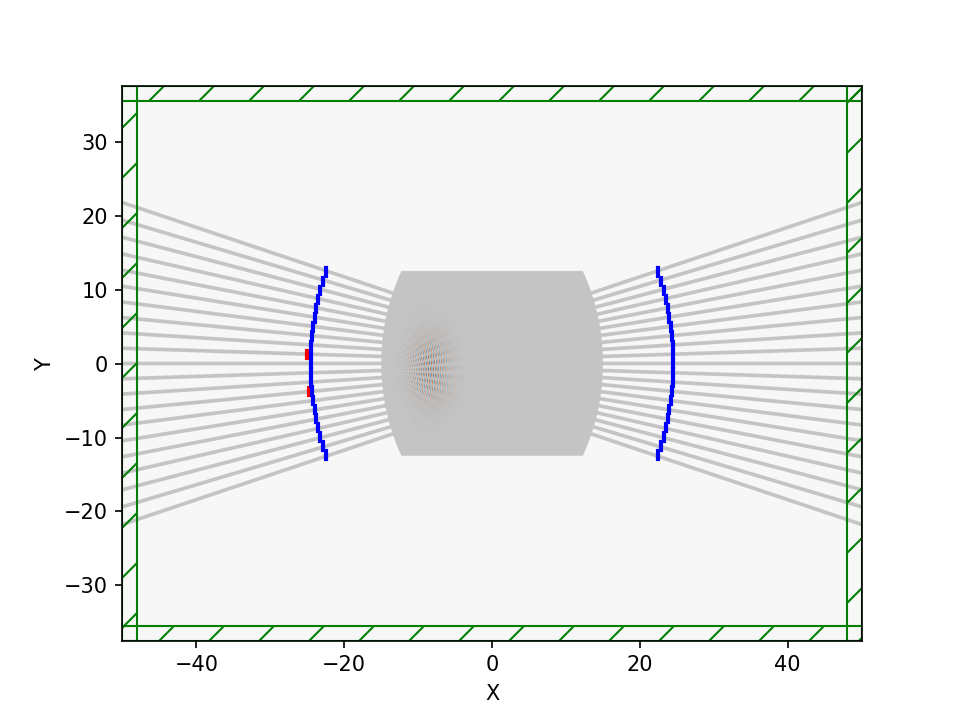

Generating MP4...


In [10]:
# sim.run(until=300)

f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
sim.run(mp.at_every(0.5, Animate), until=100)
plt.show()
from IPython.display import Video

filename = "star_coupler.mp4"
fps = 10
Animate.to_mp4(fps, filename)
Video(filename)


### Visualize E-field

     block, center = (0,0,0)
          size (59.9667,37.4667,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (32.4122,-15.8771,0)
          size (100,0.5,1e+20)
          axes (0.948244,-0.317542,0), (0.317542,0.948244,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (32.9147,-14.2894,0)
          size (100,0.5,1e+20)
          axes (0.958293,-0.285787,0), (0.285787,0.958293,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.3598,-12.7017,0)
          size (100,0.5,1e+20)
          axes (0.967195,-0.254033,0), (0.254033,0.967195,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.7492,-11.114,0)
          size (100,0.5,1e+20)
          axes (0.974983,-0.222279,0), (0.222279,0.974983,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (34.0841,-9.52625,0)
          size (100,0.5,1e+20)
          a

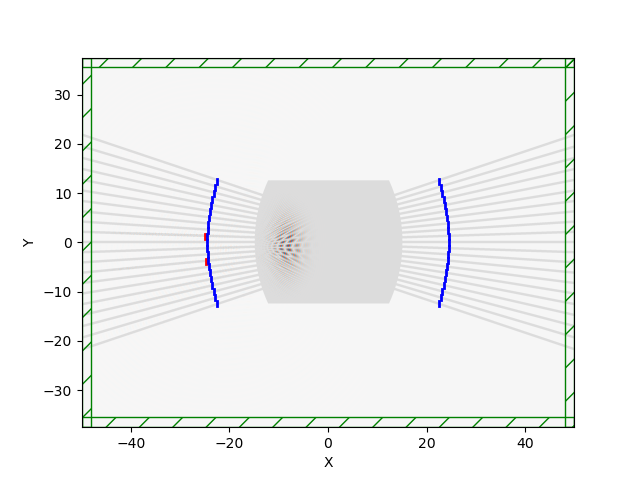

In [11]:
from matplotlib.backends.backend_pdf import PdfPages 


figure,axes = plt.subplots()

fig1 = sim.plot2D(ax=axes,output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(l,w,0)),
               fields=mp.Ez,
               field_parameters={'alpha':0.9})

In [12]:
print("Input Monitors:");
for i in range(len(input_monitors)):
     print(mp.get_fluxes(input_monitors[i]), " --> ", mp.get_fluxes(output_monitors[i]))


waveguides = []
for i in range(len(input_monitors)):
    waveguides.append(str(i))

input_flux = []
output_flux = []

total_input = 0
total_output = 0

for i in range(len(input_monitors)):
    input_flux.append(mp.get_fluxes(input_monitors[i])[0])
    total_input += mp.get_fluxes(input_monitors[i])[0]

    output_flux.append(mp.get_fluxes(output_monitors[i])[0])
    total_output += mp.get_fluxes(output_monitors[i])[0]


print("Total input: ", total_input)
print("Total output: ", total_output)

Input Monitors:
[0.0001000587565231972]  -->  [1.0191959300883898e-18]
[-1.4848544693441265e-05]  -->  [4.4664202673131306e-20]
[-0.0028309591454906266]  -->  [1.1873019871183836e-21]
[-0.0026899393857791345]  -->  [1.7162086544388026e-23]
[-0.008264153938852756]  -->  [8.1973332650946e-24]
[-0.008479478635186997]  -->  [6.859047183743157e-25]
[-0.013132983323569145]  -->  [1.991927397620863e-26]
[61.263258841300555]  -->  [4.806716613529511e-29]
[-0.009931743892307802]  -->  [1.8028010102826645e-38]
[-0.007084906025878536]  -->  [2.857998944563478e-54]
[-0.00536166140517432]  -->  [1.9588741270249368e-38]
[59.868742384305676]  -->  [4.2388073474395653e-29]
[-0.014232287227539895]  -->  [1.2506976332137395e-26]
[-0.0023307317155864993]  -->  [5.2395787032994905e-25]
[-0.0005808224504318498]  -->  [6.123761345681183e-24]
[-6.775068110782729e-05]  -->  [1.7403186185043357e-23]
[-6.343585461025194e-05]  -->  [4.036440744266167e-22]
[-8.961887864338686e-05]  -->  [1.861206777613549e-20]
[-

Bar Graphs for Flux

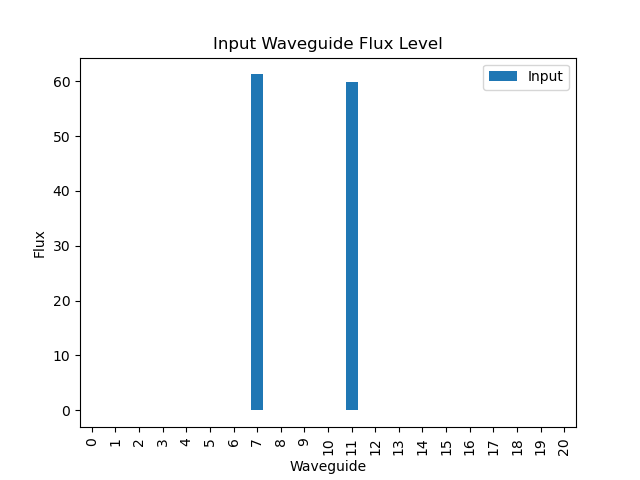

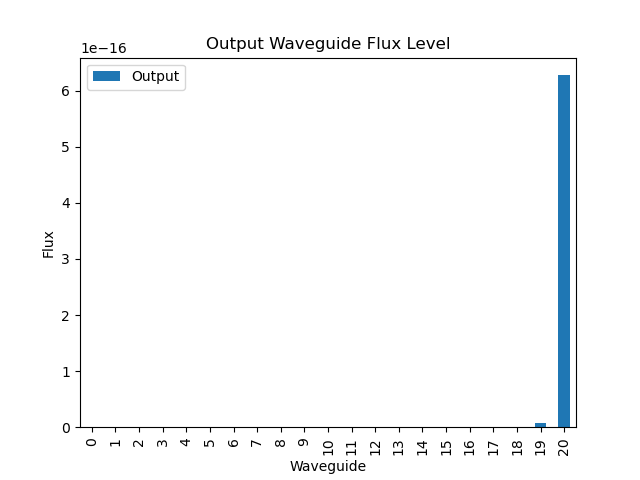

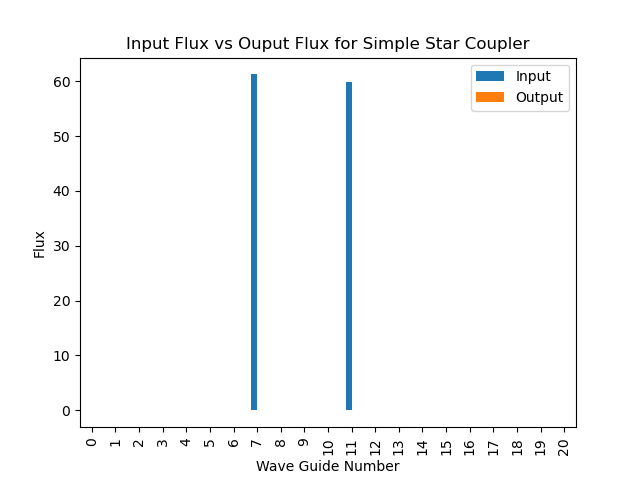

In [13]:
# Make a data definition
data_input = {'Input': input_flux}
df_input = pd.DataFrame(data_input,columns=['Input'], index = waveguides)

# Multiple bar chart
fig2 = df_input.plot.bar()
plt.title('Input Waveguide Flux Level')
plt.xlabel('Waveguide')
plt.ylabel('Flux')

# Display the plot
plt.show()


# Make a data definition
data_output = {'Output': output_flux}
df_output = pd.DataFrame(data_output,columns=['Output'], index = waveguides)

# Multiple bar chart
fig3 = df_output.plot.bar()
plt.title('Output Waveguide Flux Level')
plt.xlabel('Waveguide')
plt.ylabel('Flux')
# Display the plot
plt.show()

# Make a data definition
data_comparison = {
    'Input': input_flux,
    'Output': output_flux
    }
df_comparison = pd.DataFrame(data_comparison,columns=['Input','Output'], index = waveguides)

# Multiple bar chart
fig4 = df_comparison.plot.bar()
plt.title("Input Flux vs Ouput Flux for Simple Star Coupler")
plt.xlabel("Wave Guide Number")
plt.ylabel("Flux")

# Display the plot
plt.show()


p = PdfPages("output_graphs.pdf")
figs = [fig1, fig2, fig3, fig4]

fig1.set_title("Efficiency = " + (str)(100*(total_output/total_input)) + "%")
for fig in figs:
    fig.figure.savefig(p, format='pdf')

p.close()
